# Question 13

The features derived from such a network might have discriminative power for a custom dataset because the VGG network trained on ImageNet learns general visual patterns instead of raw pixels / specific classes. The early layers learns basic features of the flowers while deeper layers learn the overall structure and shape in greater detail. Transfer learning here works by creating similar feature representations for images with similar visual characteristics. This allows classfication and clustering to work effectively and have discriminative power for a custom dataset.

In [ ]:
import tarfile
import requests
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3060


In [ ]:
import os
import numpy as np
import gc

filename = './flowers_features_and_labels.npz'

try:
    file = np.load(filename)
    file.close()
except:
    pass

gc.collect()

if os.path.exists(filename):
    os.remove(filename)
    print("Deleted:", filename)
else:
    print("File does not exist.")


Deleted: ./flowers_features_and_labels.npz


In [13]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['features'], file['labels']
    print("Loaded cached features:", filename, f_all.shape, y_all.shape)

else:
    if not os.path.exists('./flower_photos'):
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        print("Downloading:", url)
        with open('./flower_photos.tgz', 'wb') as f:
            f.write(requests.get(url).content)

        print("Extracting...")
        with tarfile.open('./flower_photos.tgz') as f:
            f.extractall('./')

        os.remove('./flower_photos.tgz')
        print("Done.")

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            self.pooling = vgg.avgpool
            self.flatten = nn.Flatten()
            self.fc = vgg.classifier[0]

        def forward(self, x):
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    assert torch.cuda.is_available(), "CUDA not available. Fix your PyTorch CUDA install."
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(
        root='./flower_photos',
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    )

    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu().numpy()])
            y_all = np.concatenate([y_all, y.numpy()])

    np.savez(filename, f_all=f_all, y_all=y_all)
    print("Saved features:", filename, f_all.shape, y_all.shape)


Downloading: http://download.tensorflow.org/example_images/flower_photos.tgz
Extracting...
Done.


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Joel/.cache\torch\hub\v0.10.0.zip
c:\Users\Joel\ECE 219 Project 2\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Joel\ECE 219 Project 2\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


Saved features: ./flowers_features_and_labels.npz (3670, 4096) (3670,)


# Question 14
The helper code performs feature extraction by loading the flowers dataset using a PyTorch ImageFolder and DataLoader, then passing each image through the pretrained VGG16 model defined in the FeatureExtractor class. The code runs the images through self.vgg.features, applies self.vgg.avgpool, flattens the output, and passes it through self.vgg.classifier[0] to produce a dense feature vector for each image. The model is set to evaluation mode using model.eval() and wrapped in torch.no_grad() so it does not train, only extracts features. These feature vectors are collected and saved to a file, and they are later used for clustering and dimensionality reduction.

In [ ]:
sample_img, sample_label = dataset[0]
print("Image tensor shape (C, H, W):", sample_img.shape)

C, H, W = sample_img.shape
pixel_count = C * H * W

print("Number of pixels per image:", pixel_count)
print(f"Calculation: {C} × {H} × {W} =", pixel_count)

sample_img_batch = sample_img.unsqueeze(0).cuda()

with torch.no_grad():
    sample_features = feature_extractor(sample_img_batch)

print("Feature vector shape:", sample_features.shape)

feature_dim = sample_features.shape[1]
print("Feature dimension per image:", feature_dim)

print("\nSaved feature matrix shape:", f_all.shape)
print("Each row dimension:", f_all.shape[1])


Image tensor shape (C, H, W): torch.Size([3, 224, 224])
Number of pixels per image: 150528
Calculation: 3 × 224 × 224 = 150528
Feature vector shape: torch.Size([1, 4096])
Feature dimension per image: 4096

Saved feature matrix shape: (3670, 4096)
Each row dimension: 4096


# Question 15

How many pixels are there in the original images?

    150528

How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?

    (4096, )

# Question 16
The extracted VGG features are dense, since most of the 4096 values in each feature vector are non-zero. TF-IDF features are sparse, since most entries are zero because each document only contains a small number of words from the full vocabulary.

Running t-SNE...
t-SNE output shape: (3670, 2)


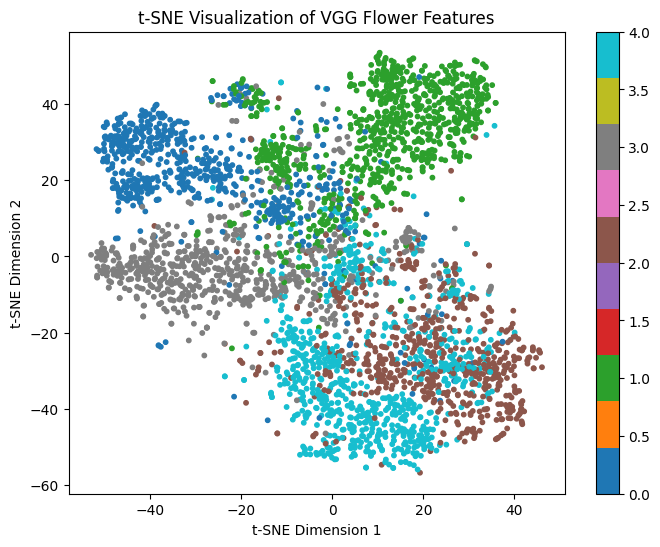

In [ ]:
# Question 17

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X = f_all
y = y_all

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init='pca'
)

X_2d = tsne.fit_transform(X)

print("t-SNE shape:", X_2d.shape)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y,
    cmap='tab10',
    s=10
)

plt.title("t-SNE Visualization of VGG Flower Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter)
plt.show()


The t-SNE visualization shows that the VGG features form distinct clusters corresponding to different flower classes. Images from the same class tend to group closely together, while different classes are separated into different regions of the plot. So VGG did a pretty good job at distinguishing meaningful features into clusters.

In [20]:
# Question 18

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Autoencoder:
    def __init__(self, num_features=50, epochs=20, batch_size=128, lr=1e-3):
        self.num_features = num_features
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        input_dim = X.shape[1]

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_features)
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        ).to(self.device)

        self.model = nn.Sequential(self.encoder, self.decoder)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        dataset = torch.utils.data.TensorDataset(X_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        print("Training autoencoder...")

        for epoch in range(self.epochs):
            total_loss = 0

            for (batch,) in loader:
                optimizer.zero_grad()
                recon = self.model(batch)
                loss = criterion(recon, batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {total_loss:.4f}")

    def transform(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            encoded = self.encoder(X_tensor)

        return encoded.cpu().numpy()


In [ ]:
# Question 18

import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import adjusted_rand_score
import umap
import hdbscan

X_dict = {}

# None
X_dict["None"] = f_all

# SVD r=50
svd = TruncatedSVD(n_components=50, random_state=42)
X_dict["SVD(50)"] = svd.fit_transform(f_all)

# UMAP n_components=50
umap_model = umap.UMAP(n_components=50, random_state=42)
X_dict["UMAP(50)"] = umap_model.fit_transform(f_all)

# Autoencoder num_features=50
auto = Autoencoder(num_features=50)
auto.fit(f_all)
X_dict["Autoencoder(50)"] = auto.transform(f_all)

print("Prepared representations:")
for k, v in X_dict.items():
    print(f"  {k:15s} -> {v.shape}")

def run_kmeans(X):
    model = KMeans(n_clusters=5, random_state=42)
    pred = model.fit_predict(X)
    return adjusted_rand_score(y_all, pred), None

def run_agglomerative(X):
    model = AgglomerativeClustering(n_clusters=5)
    pred = model.fit_predict(X)
    return adjusted_rand_score(y_all, pred), None

def run_hdbscan_grid(X):
    grid_min_cluster_size = [5, 10, 20, 30]
    grid_min_samples = [5, 10, 20]

    best_ari = -1
    best_params = None

    for mcs in grid_min_cluster_size:
        for ms in grid_min_samples:
            model = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
            pred = model.fit_predict(X)
            ari = adjusted_rand_score(y_all, pred)

            if ari > best_ari:
                best_ari = ari
                best_params = {"min_cluster_size": mcs, "min_samples": ms}

    return best_ari, best_params

results = []

for rep_name, X in X_dict.items():
    # KMeans
    ari, params = run_kmeans(X)
    results.append((rep_name, "KMeans(k=5)", ari, params))

    # Agglomerative
    ari, params = run_agglomerative(X)
    results.append((rep_name, "Agglomerative(n=5)", ari, params))

    # HDBSCAN (grid)
    ari, params = run_hdbscan_grid(X)
    results.append((rep_name, "HDBSCAN(grid)", ari, params))


results_sorted = sorted(results, key=lambda x: x[2], reverse=True)

print("\nQ18 Results (sorted by ARI)")
print(f"{'DimRed':18s} | {'Clustering':20s} | {'ARI':8s} | Params")
print("-" * 80)
for rep_name, clus_name, ari, params in results_sorted:
    if params is None:
        params_str = "-"
    else:
        params_str = str(params)
    print(f"{rep_name:18s} | {clus_name:20s} | {ari:8.4f} | {params_str}")

best = results_sorted[0]
print("\nBEST RESULT")
print("Dimensionality Reduction:", best[0])
print("Clustering:", best[1])
print("Best ARI:", best[2])
print("Best Params:", best[3])


c:\Users\Joel\ECE 219 Project 2\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Training autoencoder...
Epoch 1/20, Loss: 160.3428
Epoch 2/20, Loss: 94.1852
Epoch 3/20, Loss: 75.4417
Epoch 4/20, Loss: 64.6104
Epoch 5/20, Loss: 57.5019
Epoch 6/20, Loss: 52.7158
Epoch 7/20, Loss: 49.4009
Epoch 8/20, Loss: 46.4215
Epoch 9/20, Loss: 44.5478
Epoch 10/20, Loss: 42.7910
Epoch 11/20, Loss: 41.3730
Epoch 12/20, Loss: 39.8896
Epoch 13/20, Loss: 38.7674
Epoch 14/20, Loss: 37.9147
Epoch 15/20, Loss: 37.0201
Epoch 16/20, Loss: 36.2393
Epoch 17/20, Loss: 35.5864
Epoch 18/20, Loss: 34.9873
Epoch 19/20, Loss: 34.5485
Epoch 20/20, Loss: 34.0663
Prepared representations:
  None            -> (3670, 4096)
  SVD(50)         -> (3670, 50)
  UMAP(50)        -> (3670, 50)
  Autoencoder(50) -> (3670, 50)

=== Q18 Results (sorted by ARI) ===
DimRed             | Clustering           | ARI      | Params
--------------------------------------------------------------------------------
UMAP(50)           | KMeans(k=5)          |   0.4123 | -
UMAP(50)           | Agglomerative(n=5)   |   0.354

The best result was obtained using UMAP(50) followed by K-Means clustering (k=5), achieving an Adjusted Rand Index of 0.4123.

In [22]:
# Question 19
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    f_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2936, 4096)
Test shape: (734, 4096)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP3(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [24]:
def train_mlp(X_train, y_train, X_test, y_test, epochs=20):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

    model = MLP3(input_dim=X_train.shape[1]).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):

        model.train()

        optimizer.zero_grad()

        outputs = model(X_train_t)

        loss = criterion(outputs, y_train_t)

        loss.backward()

        optimizer.step()

    model.eval()

    with torch.no_grad():

        outputs = model(X_test_t)

        preds = torch.argmax(outputs, dim=1)

        accuracy = (preds == y_test_t).float().mean().item()

    return accuracy


In [25]:
acc_original = train_mlp(X_train, y_train, X_test, y_test)
print("MLP Accuracy (Original VGG features):", acc_original)

X_umap = X_dict["UMAP(50)"]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_umap,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

acc_reduced = train_mlp(X_train_r, y_train_r, X_test_r, y_test_r)
print("MLP Accuracy (Reduced UMAP features):", acc_reduced)

MLP Accuracy (Original VGG features): 0.8732969760894775
MLP Accuracy (Reduced UMAP features): 0.6062670350074768


Does the performance of the model suffer with the reduced-dimension representations? Is it significant? 
    Yes. It decreased significantly which shows that important information was lost in the reduction.

Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 18.
    Yes, because the VGG features in question 18 contain more information. Classification was impacted since it lost some information needed, but UMAP still helped in clustering.